In [1]:
# Import 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

import sys
sys.path.append('../')
from helpers import cm2inch, title, show_num_contours, load_datasets
from melodic_contour import *
from sklearn import metrics

import tslearn
matplotlib.style.use('styles.mplstyle')

# Contour/timeseries derivative

Goal of this notebook is to convert a matrix of contours into a matrix of contour derivatives. We are not computing actual derivatives, but approximating the derivatives in two different ways. First, given a contour $X = (x_1, \dots, x_n)$ 

$$X' = (x_2-x_1, x_3-x_2, \dots, x_n-x_{n-1}, 0)$$

This is simply the interval from every pitch to the next, and the final interval is set to 0 (the final note has some duration).

This is closely related to derivative dynamic time warping, but slightly different. There smoothen the derivative by taking the average of the slope between the previous and the current point, and the slope between the previous and the next point:

$$x'_i = \frac{1}{2}\Bigl[ \frac{x_i - x_{i-1}}{1} + \frac{x_{i+1} - x_{i-1}}{2}\Bigr] $$

Moreover, as the cost function in DWT they do not use the Euclidian distance but the squared difference between the derivatives.

In [57]:
contours = np.array([
    [1, 1, 1, 1, 1, 1, 1],
    [1, 2, 3, 4, 3, 2, 1],
    [1, 2, 3, 4, 5, 6, 7],
    [7, 6, 5, 4, 3, 2, 1],
    [3, 4, 3, 2, 1, 2, 3]
])

In [82]:
def derivative(timeseries):
    d = (timeseries[:,1:] - timeseries[:, :-1])
    d = np.append(d, np.zeros((timeseries.shape[0], 1)), axis=1)
    return d

In [74]:
d1 = (contours[:, 1:] - contours[:, :-1]) / 1
d2 = (contours[:, 2:] - contours[:, :-2]) / 2

In [87]:
d = (d1[:, 1:] + d2) / 2

In [97]:
def derivative(timeseries, smooth=False):
    d1 = timeseries[:, 1:] - timeseries[:, :-1]
    zeros = np.zeros((timeseries.shape[0], 1))
    if smooth:
        d2 = (timeseries[:, 2:] - timeseries[:, :-2]) / 2
        avg = (d1[:, 1:] + d2) / 2
        return np.concatenate((zeros, avg, zeros), axis=1) 
    else:
        return np.append(d1, zeros, axis=1) 

derivative(contours)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1., -1., -1., -1.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  0.],
       [-1., -1., -1., -1., -1., -1.,  0.],
       [ 1., -1., -1., -1.,  1.,  1.,  0.]])

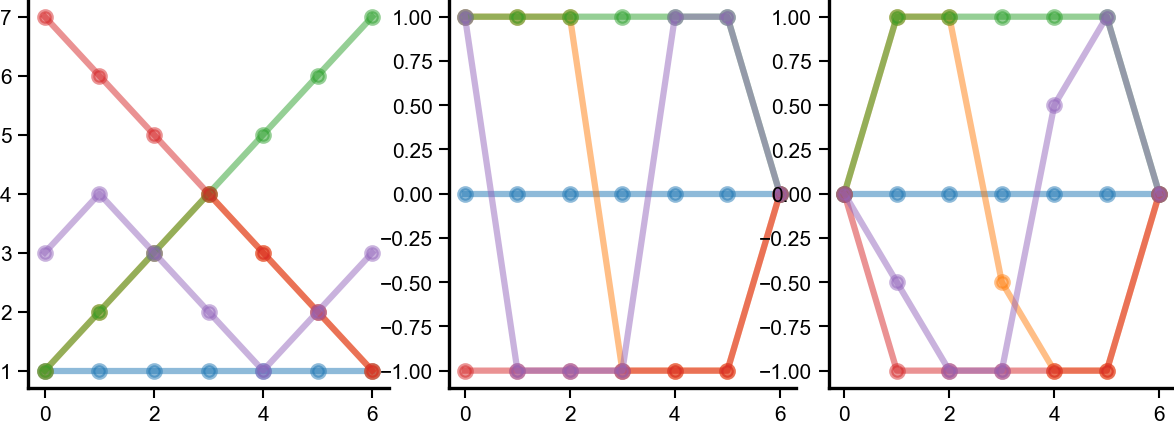

In [96]:
plt.figure(figsize=(4, 1.5))
plt.subplot(131)
plt.plot(contours.T, marker='o', alpha=.5)
plt.subplot(132)
plt.plot(derivative(contours, smooth=False).T, marker='o', alpha=.5)
plt.subplot(133)
plt.plot(derivative(contours, smooth=True).T, marker='o', alpha=.5)

In [98]:
intervals = derivative(contours, smooth=False)

In [103]:
intervals

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1., -1., -1., -1.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  0.],
       [-1., -1., -1., -1., -1., -1.,  0.],
       [ 1., -1., -1., -1.,  1.,  1.,  0.]])

In [116]:
def integrate(derivatives):
    return np.append(
        np.zeros((derivatives.shape[0], 1)), 
        np.cumsum(derivatives, axis=1)[:, :-1], 
        axis=1)

integrate(intervals)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  2.,  3.,  2.,  1.,  0.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.],
       [ 0., -1., -2., -3., -4., -5., -6.],
       [ 0.,  1.,  0., -1., -2., -1.,  0.]])

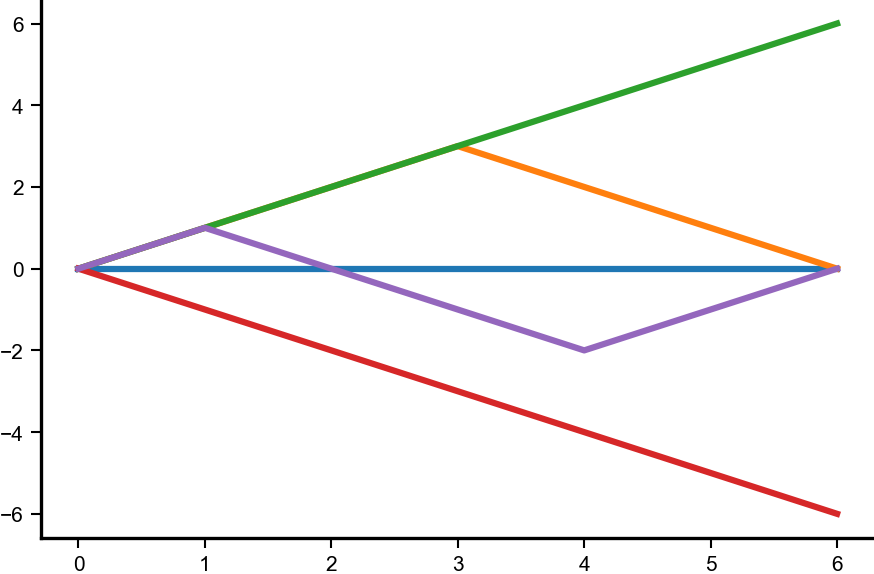

In [117]:
plt.figure(figsize=(3, 2))
plt.plot(integrate(intervals).T)